# DwarfGAN - Deep Learning based Map Design for Dwarf Fortress

### Setup and Imports

In [15]:
""" 

loosely based on example coded provided in Foster, 2019 see:

basic GAN
"G:\Dev\DataScience\GDL_code\models\GAN.py"

Wasserstein GAN
"G:\Dev\DataScience\GDL_code\models\WGAN.py"

Wasserstein GAN with Gradient Penatly
"G:\Dev\DataScience\GDL_code\models\WGANGP.py"

"""
# imports
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.experimental import preprocessing
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.losses import binary_crossentropy
from functools import partial

import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import pathlib
import tensorflow as tf
import io
import random

#!pip install boto3
import boto3 as b3 


print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

############### CONFIG ###################

# model name
model_name = 'dwarfgan001WGANGPR01'
# folder path to input files (map images)
fpath = r'/data/input'
# folder path to tensorboard output
tboard_dir = '/data/output/tensorboard'
# folder path for saved model output
out_model_dir = '/data/output/models'
# frequency of checkpoint saves (images, model weights) in epochs
CHECKPOINT = 50
LATENT_DIM = 100
BATCH_PER_EPOCH = 20
# pre-processed (cropped) images are 1024x1024. We will later resize the images to 256x256 due to memory restrictions.
IMAGE_SIZE = (256,256)
BATCH_SIZE = 64

# NOTE: all extracted map PNGs have been saved on a separate virtual disk mapped to '/data' of the virtual machine in use
data_dir = pathlib.Path(fpath + '/maps')
imgs = list(data_dir.glob('*.png'))

##########################################

2.3.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### Check available Samples from S3 Bucket

simmler_qualitai_goldstandard_full
storage_hil
Found 119564 images in S3 storage


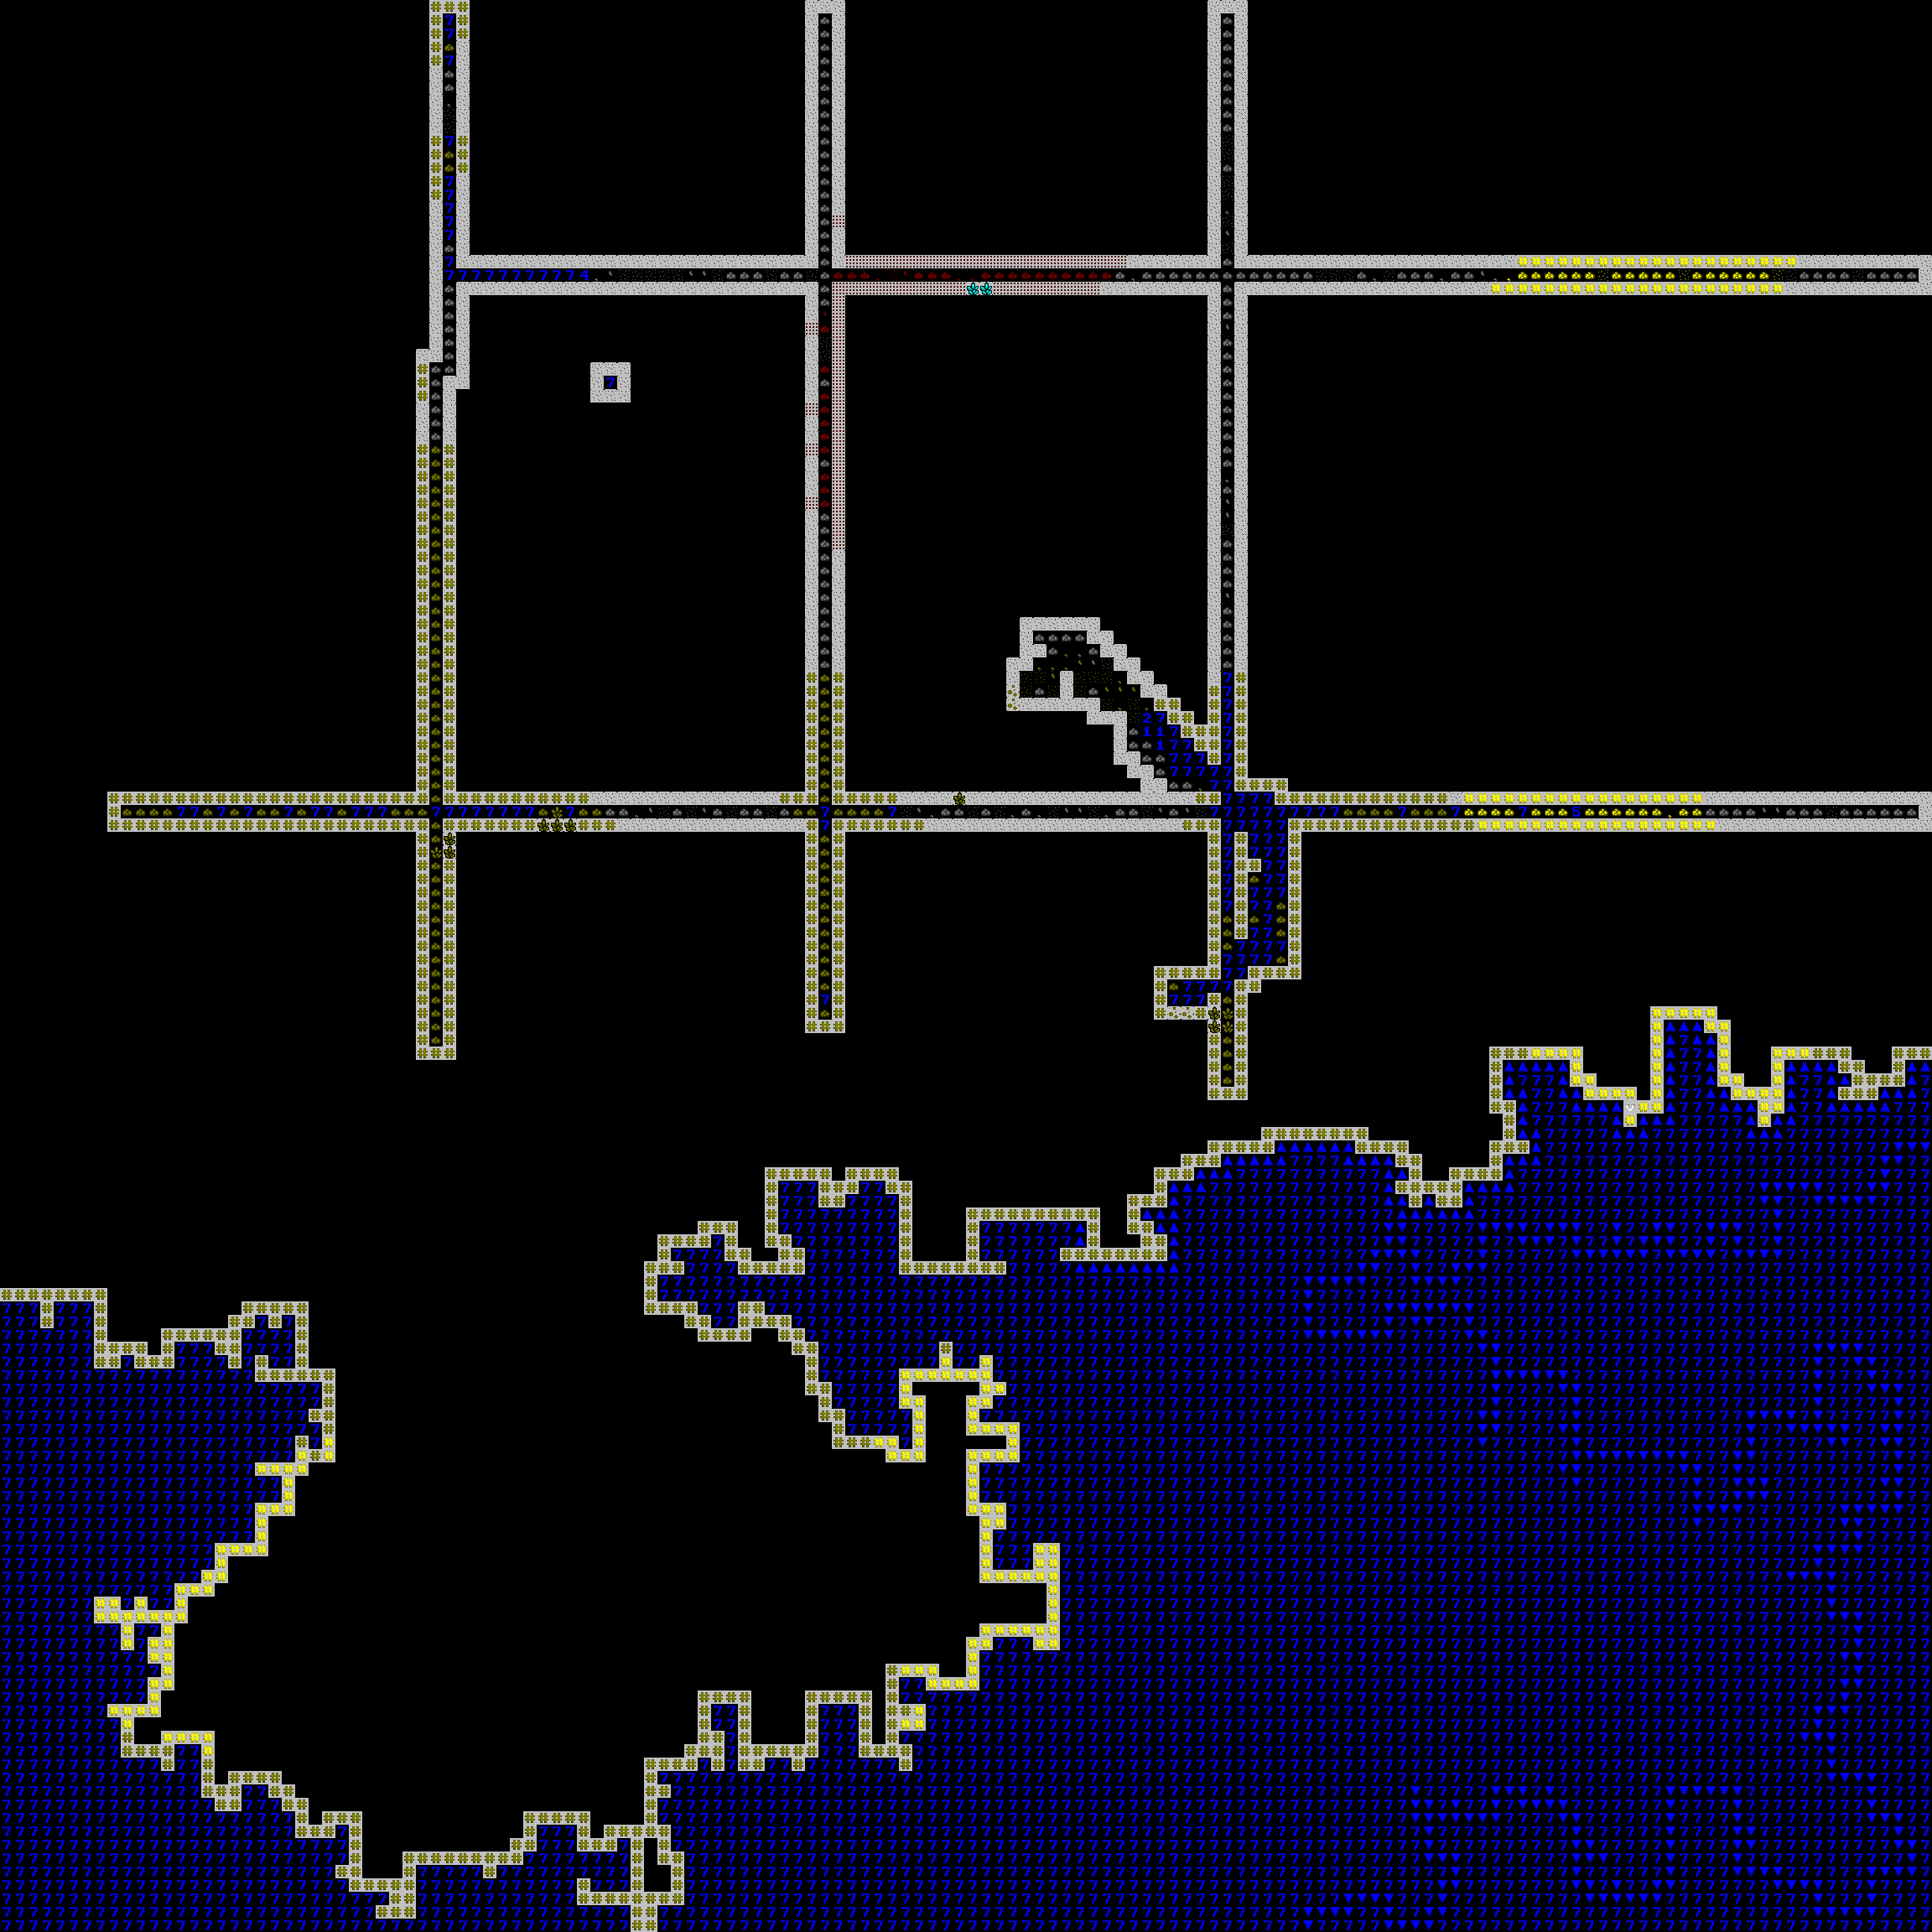

In [4]:
# Load from Switch S3 bucket
s3 = b3.resource('s3',
                 region_name='ZH',
                 endpoint_url='https://os.zhdk.cloud.switch.ch',
                 aws_access_key_id='',    # needs to be specified. Willfully ommited due to security concerns
                 aws_secret_access_key='' # needs to be specified. Willfully ommited due to security concerns
                 )

# check connection
for bucket in s3.buckets.all():
    print(bucket.name)


obj = s3.Object('storage_hil', 'maps/map_1.png')
# get list of files
my_bucket = s3.Bucket('storage_hil')
filelist = [e.key for e in my_bucket.objects.filter(Prefix='maps/')]
print(f'Found {len(filelist)} images in S3 storage')

# get example file from S3 storage and read as Byte stream
img = io.BytesIO(obj.get()['Body'].read())

# Visualize image from S3 bucket
PIL.Image.open(img)

### Data Load and Train / Validation Split

The map images sourced from the DFMA come in a variety of dimensions. In order to create sample images with constant dimensions, as required by tensors, the 100k input samples were run through a python script to randomly crop 10 1024 x 1024 areas per picture. Of those cropped (sub-)images, only the ones which contain structures were retained. This was achieved by filtering out image crops which only contained two or less different colors. With that, the logic mainly filterd out crops which only contained black. This process resulted in 700'000+ (sub-)image samples.

In [17]:
# use pre-processed (cropped) 256 x 256 images
data_dir = pathlib.Path(fpath + '/crops_small/maps')
imgs = list(data_dir.glob('*.png'))
print(f'There are {str(len(imgs))} cropped image samples available')

There are 488044 cropped image samples available


A random sample input image:


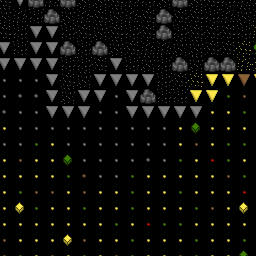

In [30]:
# show example sample image (cropped to 256x256)
print('A random sample input image:')
PIL.Image.open(imgs[random.randint(0,len(imgs))])

In [31]:


# creating keras datasets for training and validation - refer to https://www.tensorflow.org/tutorials/images/classification
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(  fpath,
                                                                      image_size=IMAGE_SIZE, 
                                                                      batch_size=BATCH_SIZE, 
                                                                      labels=[1.] * len(imgs), # setting all labels to 1.0 (for 'real') as float32
                                                                      #label_mode=None, # yields float32 type labels
                                                                      seed=42,
                                                                      validation_split=0.5, # due to the large number of images, we split out more into the validation set (which is not being used)
                                                                      subset='training'
                                                                    )

dataset_val = tf.keras.preprocessing.image_dataset_from_directory(  fpath,
                                                                    image_size=IMAGE_SIZE, 
                                                                    batch_size=BATCH_SIZE, 
                                                                    labels=[1.] * len(imgs), # setting all labels to 1.0 (for 'real') as float32
                                                                    #label_mode=None, # yields float32 type labels
                                                                    seed=42,
                                                                    validation_split=0.5,
                                                                    subset='validation'
                                                                    )


# refer to https://www.tensorflow.org/tutorials/images/classification
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = dataset_train.cache().prefetch(buffer_size=BATCH_SIZE)
val_ds = dataset_val.cache().prefetch(buffer_size=BATCH_SIZE)


Found 488044 files belonging to 1 classes.
Using 244022 files for training.
Found 488044 files belonging to 1 classes.
Using 244022 files for validation.


### Check Random Sample Dataset

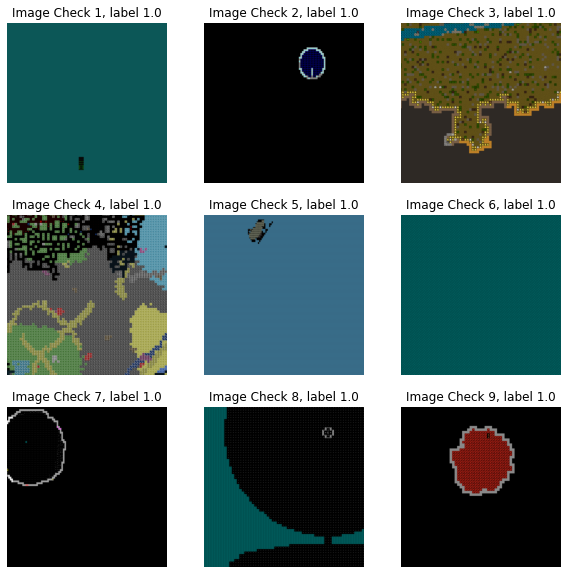

In [5]:
# Check random images from prepared batches
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # take one batch. Here batch_size = 16 examples per batch
    for i in range(9): # show first 9 images of batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'Image Check {i+1}, label {labels[i]}')
        plt.axis('off')

### Discriminator Model Definition

In [6]:
def discriminator_model():

    # DISCRIMINATOR
    # set input variables to variable width + height. Will be cropped in preprocessing [CURRENTLY FIXED TO 256x256]
    input_dim = (256, 256, 3)

    # Input
    d_input = Input(shape=input_dim, name='Discriminator_Input')

    # ---- REMOVED FOR 256x256 NETWORK ----------
    # Keras-based preprocessing. Alternative: RandomCrop()
    # use smart_resizing?
    #x = tf.keras.preprocessing.image.smart_resize(d_input, (1024, 1024))
    #x = preprocessing.Resizing(width=512, 
    #                           height=512, 
    #                           name='Preprocessing_Resize'
    #                          )(d_input) # Resize to 512 x 512 images

    #x = preprocessing.RandomCrop(height=512, 
    #                            width=512, 
    #                            name = 'Preprocessing_RandomCrop'
    #                           )(d_input)

    x = preprocessing.Rescaling(scale=1./127.5, 
                                offset=-1,
                                name='Preprocessing_Rescale'
                               )(d_input) # Rescale values from [0,255] to [-1,1] see https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling


    # Conv2D Layer 1
    x = Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = 2,
            padding = 'same',
            kernel_initializer = RandomNormal(mean=0., stddev=0.02),
            name = 'Discriminator_Conv2D_Layer_1'
    )(x)

    # BatchNorm Layer 1
    #x = BatchNormalization()(x)

    # Activation 1 - Leaky ReLU
    x = LeakyReLU(alpha = 0.1, name='Activation_1')(x)

    # Dropout 1
    #x = Dropout(rate = 0.4)(x)


    # Conv2D Layer 2
    x = Conv2D(
            filters = 128,
            kernel_size = 3,
            strides = 2,
            padding = 'same',
            name = 'Discriminator_Conv2D_Layer_2',
            kernel_initializer = RandomNormal(mean=0., stddev=0.02)
    )(x)

    # BatchNorm Layer 2
    #x = BatchNormalization()(x)

    # Activation 2 - Leaky ReLU
    x = LeakyReLU(alpha = 0.1, name='Activation_2')(x)

    # Dropout 2
    #x = Dropout(rate = 0.4)(x)


    # Conv2D Layer 3
    x = Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = 2,
            padding = 'same',
            name = 'Discriminator_Conv2D_Layer_3',
            kernel_initializer = RandomNormal(mean=0., stddev=0.02)
    )(x)

    # BatchNorm Layer 3
    #x = BatchNormalization()(x)

    # Activation 3 - Leaky ReLU
    x = LeakyReLU(alpha = 0.1, name='Activation_3')(x)

    # Dropout 3
    #x = Dropout(rate = 0.4)(x)



    # Conv2D Layer 4
    x = Conv2D(filters = 128,
               kernel_size = 5,
               strides = 2,
               padding = 'same',
               name = 'Discriminator_Conv2D_Layer_4',
               kernel_initializer = RandomNormal(mean=0., stddev=0.02)
    )(x)

    # BatchNorm Layer 4
    #x = BatchNormalization()(x)

    # Activation 4 - Leaky ReLU
    x = LeakyReLU(alpha = 0.1, name='Activation_4')(x)

    # Dropout 4
    #x = Dropout(rate = 0.4)(x)




    # Conv2D Layer 5
    x = Conv2D(filters = 64,
               kernel_size = 5,
               strides = 2,
               padding = 'same',
               name = 'Discriminator_Conv2D_Layer_5',
               kernel_initializer = RandomNormal(mean=0., stddev=0.02)
    )(x)

    # BatchNorm Layer 5
    # x = BatchNormalization()(x)

    # Activation 5 - Leaky ReLU
    x = LeakyReLU(alpha = 0.1, name='Activation_5')(x)

    # Dropout 5
    #x = Dropout(rate = 0.4)(x)


    # OUTPUT
    x = Flatten()(x)
    d_output = Dense(1, 
                     #activation='sigmoid', 
                     kernel_initializer = RandomNormal(mean=0, stddev=0.02) # random initialization of weights with normal distribution around 0 with small SD
                    )(x)



    # Discriminator Model intialization
    discriminator = Model(d_input, d_output, name='Discriminator')
    
    
    
    return discriminator



### Generator Model Definition

In [7]:
def generator_model():

    # GENERATOR

    # set input variable dimensions. Here we will start out with a vector of length 100 for each sample (sampled from a normal distribution, representing the learned latent space)
    input_dim = (100)

    # Input
    g_input = Input(shape=input_dim, name='Generator_Input')

    # Dense Layer 1
    x = Dense(np.prod([16,16,32]), kernel_initializer = RandomNormal(mean=0., stddev=0.02))(g_input) # use_bias=False ?

    # Batch Norm Layer 1
    x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 1
    x = LeakyReLU(alpha=0.2)(x) # trying leaky ReLU instead of Activation('relu')(x)

    # Reshape into 3D tensor
    x = Reshape((16,16,32))(x)

    # Upsampling Layer 1 + Conv2D Layer1
    #x = UpSampling2D()(x)
    #x = Conv2D(filters=64, kernel_size=5, padding='same', name='Generator_Conv_Layer_1')(x)
    # Replacing by Conv2DTranspose Layer
    x = Conv2DTranspose(filters=64, kernel_size=3, padding='same', strides=(2,2), kernel_initializer = RandomNormal(mean=0., stddev=0.02))(x)
    
    
    # Batch Norm Layer 2
    x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 2
    x = LeakyReLU(alpha=0.2)(x) # trying leaky ReLU instead of Activation('relu')(x)

    # Upsampling Layer 2 + Conv2D Layer2
    #x = UpSampling2D()(x)
    #x = Conv2D(filters=128, kernel_size=5, padding='same', name='Generator_Conv_Layer_2')(x)
    # Replacing by Conv2DTranspose Layer
    x = Conv2DTranspose(filters=128, kernel_size=5, padding='same', strides=(2,2), kernel_initializer = RandomNormal(mean=0., stddev=0.02))(x)

    # Batch Norm Layer 3
    x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 3
    x = LeakyReLU(alpha=0.2)(x) # trying leaky ReLU instead of Activation('relu')(x)

    # Upsampling Layer 3 + Conv2D Layer3
    #x = UpSampling2D()(x)
    #x = Conv2D(filters=64, kernel_size=5, padding='same', name='Generator_Conv_Layer_3')(x)
    # Replacing by Conv2DTranspose Layer
    x = Conv2DTranspose(filters=256, kernel_size=5, padding='same', strides=(2,2), kernel_initializer = RandomNormal(mean=0., stddev=0.02))(x)

    # Batch Norm Layer 4
    x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 4
    x = LeakyReLU(alpha=0.2)(x) # trying leaky ReLU instead of Activation('relu')(x)

    # Upsampling Layer 4 + Conv2D Layer4
    #x = UpSampling2D()(x)
    #x = Conv2D(filters=64, kernel_size=5, padding='same', name='Generator_Conv_Layer_4')(x)
    # Replacing by Conv2DTranspose Layer
    x = Conv2DTranspose(filters=128, kernel_size=3, padding='same', strides=(2,2), kernel_initializer = RandomNormal(mean=0., stddev=0.02))(x)


    # Batch Norm Layer 5
    x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 5
    x = LeakyReLU(alpha=0.2)(x) # trying leaky ReLU instead of Activation('relu')(x)
    
    
    # Replacing by Conv2DTranspose Layer
    x = Conv2DTranspose(filters=64, kernel_size=5, padding='same', strides=(1,1), kernel_initializer = RandomNormal(mean=0., stddev=0.02))(x)


    # Batch Norm Layer 5
    x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 5
    x = LeakyReLU(alpha=0.2)(x) # trying leaky ReLU instead of Activation('relu')(x)
    
    
    # Upsampling Layer 6 + Conv2D Layer6
    #x = UpSampling2D()(x)
    #x = Conv2D(filters=3, kernel_size=5, padding='same', name='Generator_Conv_Layer_5')(x)
    # Replacing by Conv2DTranspose Layer
    #x = Conv2DTranspose(filters=3, kernel_size=(5,5), padding='same', strides=(2,2))(x)


    # Batch Norm Layer 6
    #x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 6
    #x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)


    # REMOVED FOR 256x256 PICS
    # ---------------------------
    # Upsampling Layer 5 + Conv2D Layer5
    #x = UpSampling2D()(x)
    #x = Conv2D(filters=32, kernel_size=5, padding='same', name='Generator_Conv_Layer_5')(x)


    # Batch Norm Layer 6
    #x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 6
    #x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)

    # REMOVED FOR 512x512 PICS
    # ---------------------------
    # Upsampling Layer 7 + Conv2D Layer7
    #x = UpSampling2D()(x)
    x = Conv2DTranspose(filters=3, kernel_size=5, padding='same', strides=(1,1), kernel_initializer = RandomNormal(mean=0., stddev=0.02))(x)


    # Batch Norm Layer 7
    #x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 7
    #x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)


    # Upsampling Layer 8 + Conv2D Layer8
    #x = Conv2D(filters=3, kernel_size=5, padding='same', name='Generator_Conv_Layer_7')(x)
    # ---------------------------/
    
    # tanh activation layer to scale values to [-1:1]
    x = Activation('tanh')(x)

    # Output - !!!RESCALING ADDED!!! Rescale Values back to [0:255] since the discriminator will automatically rescale back down to [-1:1] as part of the pre-processing pipeline
    g_output = 255 / 2 * (x + 1) #!!! probably need to round x to next integer value first!!!


    # Generator Model initialization
    generator = Model(g_input, g_output, name='Generator')
    
    
    return generator


### WGAN-GP (Full) Model Compilation

Before we compile the models, we need to implement a custom loss function which uses the Wasserstein distance and a gradient penalty term in order to ensure 1 Lipschitz constraints are followed. A WGAN with GP further involves a slightly more complicated training process which trains the critic (discriminator without sigmoid activation function) by feeding three different kinds of images:

1. real images (i.e. available samples)
2. 'fake' images (i.e. constructed by the generator)
3. random interpolations between real and fake images (i.e. random samples interpolated from values between the fake and real images)

The full training process of a critic is depicted below (source: Foster, 2019, p. 122):

<div align="center">
    <img src="wgan_gp_critic_training.png"></img>
    <i>Computational Graph for one Discriminator Training Epoch. (Source: Foster, 2019, p.122)</i>
</div>

In [165]:
#the following function definitions in this section have been adapted from Foster, 2019
def wasserstein(y_true, y_pred):
    return -K.mean(y_true * y_pred)

#def gp_loss(y_true, y_pred, interpolated_images, critic):
    # !!! ISSUE HERE !!! K.gradients() returns None. This is likely due to the fact that interpolated_images is not connected to an input. see: https://www.tensorflow.org/guide/autodiff?hl=en
    # --------------------------------------------------
    # should potentially use tf.gradients() and/or tf.GradientTape() context?
    # potentially issue arises from the fact that we use functools.partial() ?
    # ALTERNATIVE IMPLEMENTATION BASED ON tf.GradientTape()
    #interpol = RandomWeightedAverage()((y_true, y_pred)
    #below implementation based on https://arxiv.org/abs/1704.00028 (Gulrajani et al, 2017. paper that proposed WGAN-GP)
#    with tf.GradientTape() as t:
#        t.watch(interpolated_images)
#        pred = critic(interpolated_images)
#    gradients = K.gradients(pred, interpolated_images)[0] # tf.gradients instead of K.gradients()[0]? this results in "None" but should not
    #gradients = [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(interpolated_samples, gradients)]
    # compute the euclidean norm by squaring ...
#    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
#    gradients_sqr_sum = K.sum(gradients_sqr,
#                              axis=np.arange(1, len(gradients_sqr.shape)))
    # calculate square root
#    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
#    gradient_penalty = K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
#    return K.mean(gradient_penalty)

def set_trainable(m, val):
    m.trainable = val
    for l in m.layers:
        l.trainable = val

#in order to implement the interpolated images, we inherit functionality from the '_Merge' layer. 
#UPDATE: due to refactoring of Keras, the _Merge layer is not available anymore. Workaround used with the generic "Layer" class of Keras, see: https://stackoverflow.com/questions/58133430/how-to-substitute-keras-layers-merge-merge-in-tensorflow-keras

class RandomWeightedAverage(tf.keras.layers.Layer):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size

    def call(self, inputs, **kwargs):
        alpha = tf.random.uniform((self.batch_size, 1, 1, 1)) #tf.random.uniform((self.batch_size, 1, 1, 1)) 
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

#    def compute_output_shape(self, input_shape):
#        return input_shape[0]

    
#instead of a custom layer, the RandomWeightAverage() is implemented as a function which is used in a lambda layer of the critic model
#def RandomWeightedAverage(batch_size, inputs):
#    alpha = tf.random.uniform((batch_size, 1, 1, 1)) #tf.random.uniform((self.batch_size, 1, 1, 1))
#    return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
    

In [160]:
# Test Alternative GP Loss Implementation based on Gulrajani et al
def gradient_penalty(y_true, y_pred, interpolated_images):
        #alpha = random.uniform([BATCH_SIZE, 1, 1, 1], 0., 1.)
        #diff = fake - real
        #inter = real + (alpha * diff)
        inter = interpolated_images
        with tf.GradientTape() as t:
            t.watch(inter)
            pred = critic(inter)
        grad = t.gradient(pred, [inter])[0]
        #slopes = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1, 2, 3]))
        #gp = tf.reduce_mean((slopes - 1.)**2)
        #gp = K.mean((slopes - 1.)**2)
        
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(grad)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)
        #return gp

In [ ]:
# Check: does RandomWeightedAverage() return a tensor? yes - OK!
x = 1. * tf.ones((2,2))
l = RandomWeightedAverage(16)([x, x])
print(l)

In [175]:
# Definition of KERAS strategy for distributed training (single host, multi GPU strategy = Mirrored). See: https://keras.io/guides/distributed_training/
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

   
    critic = discriminator_model()
    generator = generator_model()
        
    # COMPILATION OF CRITIC
    # ---------------------
    set_trainable(generator, False)
    
    # real image input
    real_img = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    # fake image input
    critic_z = Input(shape=(LATENT_DIM,))
    fake_img = generator(critic_z)
    
    # run images through critic
    fake = critic(fake_img)
    valid = critic(real_img)
    
    # create interpolated images (i.e. random mixtures of real/fake images) by giving the custom layer the real and fake images created above
    #here batch_size is halved due to the multi-GPU strategy which equally distributes batches across the two available GPUs
    interpol_img = RandomWeightedAverage(int(BATCH_SIZE / 2))([real_img, fake_img]) #RandomWeightedAverage(int(BATCH_SIZE/2), [real_img, fake_img]) #Lambda(RandomWeightedAverage, arguments={'batch_size':BATCH_SIZE, 'inputs':[real_img, fake_img]})
    # check interpolated images with the critic
    validity_interpol = critic(interpol_img)
    
    # due to limitations with keras (loss functions expect exactly two inputs), the partial function is used here to circumvent
    #pgp_loss = partial(gp_loss, interpolated_images=interpol_img, critic=critic)
    #gradient_penalty(partial(interpolated_images=interpol_img, training=True), real_img, fake_img)
    pgp_loss = partial(gradient_penalty,
                       interpolated_images=interpol_img)
    
    # since Keras expects the function to be named, we do so
    pgp_loss.__name__ = 'gradient_penalty'
    
    critic_model = Model(inputs=[real_img, critic_z],
                         outputs=[valid, fake, validity_interpol],
                         name='Critic_Model'
                        )
    
    critic_model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), # per Foster, 2017 RMSprop(lr=0.0008)
                         loss=[wasserstein, wasserstein, pgp_loss], #we specify three different loss functions, one for each output of the critic (fake images, real images and interpolated images)
                         loss_weights=[1,1,10], # the over all loss is a sum of the three losses above but we specify a weight of 10 for the gradient penalty loss 
                         metrics=['accuracy'],
                         experimental_run_tf_function=False#,
                         #run_eagerly=True
                        ) 

    
    # COMPILATION OF GENERATOR/FULL GAN
    # ---------------------------------
    
    # to train the generator as part of the full GAN, we have to freeze the critic weights and ensure the generator is trainable
    set_trainable(critic, False)
    set_trainable(generator, True)

    model_input = Input(shape=(LATENT_DIM,), name='GAN_input')
    # Output of generator is a (fake) image
    img = generator(model_input)
    # which is then fed to critic
    model_output = critic(img)
    
    # The complete GAN model
    gan = Model(model_input, model_output, name='Full_GAN')

    gan.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), # here we try RMSprop instead of ADAM with a learning rate of 0.0004 (< than discriminator lr as the discriminator should be stronger than the generator)
                loss=wasserstein, # here we also use the wasserstein loss instead of binary cross entropy for the total loss
                metrics=['accuracy'])
    
    # make sure the critic is enabled again
    set_trainable(critic, True)





INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


### ALTERNATIVE GRAPH DEFINITION

In [97]:
# manual definition of training and backprop graph
def train_d(self, x_real):
        z = random.normal((self.batch_size, 1, 1, self.z_dim))
        with tf.GradientTape() as t:
            x_fake = self.G(z, training=True)
            fake_logits = self.D(x_fake, training=True)
            real_logits = self.D(x_real, training=True)
            cost = ops.d_loss_fn(fake_logits, real_logits)
            gp = self.gradient_penalty(partial(self.D, training=True), x_real, x_fake)
            cost += self.grad_penalty_weight * gp
        grad = t.gradient(cost, self.D.trainable_variables)
        self.d_opt.apply_gradients(zip(grad, self.D.trainable_variables))
        return cost

In [167]:
generator.summary()
critic.summary()
critic_model.summary()
gan.summary()


Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator_Input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_89 (Dense)             (None, 8192)              827392    
_________________________________________________________________
batch_normalization_264 (Bat (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_264 (LeakyReLU)  (None, 8192)              0         
_________________________________________________________________
reshape_44 (Reshape)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_transpose_264 (Conv2D (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_265 (Bat (None, 32, 32, 64)        25

### Training Definition

In [11]:
if pathlib.Path(f'/data/output/images/{model_name}/').exists():
    print(f'/data/output/images/{model_name} exists')
else:
    print(f'/data/output/images/{model_name}/ does not exist')

/data/output/images/dwarfgan001-WGANGP-R01/ does not exist


In [168]:
def train_critic(x_train, batch_size, step, tensorboard, batch_per_epoch):
    '''
    Train Critic on real and fake images
    '''
    tensorboard.set_model(critic_model)
    
    #make sure discriminator is trainable
    critic_model.trainable = True
    
    #iterate over pre-made batches
    for batch in range(0, batch_per_epoch):
        print(f'batch {str(batch+1)}/{str(batch_per_epoch)}', flush=True)
        for images, labels in x_train.take(1): # TRY next(x_train) instead of x_train.take(1) to take advantage of caching
            #Real Images
            #!!!Potentially better to remove introduction of randomness into samples for WGAN-GP!!!
            lbl_real = labels + 0.05 * tf.random.uniform(labels.shape) #IMPORTANT TRICK: introduce slight randomness to labels to prevent GAN from getting stuck in training
            #discriminator.train_on_batch(images, labels)

            #Generated Images
            noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
            #gen_imgs = generator.predict(noise) # random generated images of (untrained) generator
            lbl_fake = -np.ones((batch_size, 1), dtype=np.float32) # 'fake' label changed to -1 due to Wasserstein loss implementation
            #!!!Potentially better to remove introduction of randomness into samples for WGAN-GP!!!
            lbl_fake += 0.05 * tf.random.uniform(labels.shape) #IMPORTANT TRICK: introduce slight randomness to labels to prevent GAN from getting stuck in training

            #keras expects a set of labels for each output eventhough we don't use labels for the interpolated images. hence we create a dummy vector with 0s
            lbl_dummy = np.zeros((batch_size, 1), dtype=np.float32)
            history = critic_model.train_on_batch([images, noise], [lbl_real, lbl_fake, lbl_dummy]) 

    #write out to tensorboard after 1 epoch
    batch_id = step
    tensorboard.on_epoch_end(batch_id, named_logs(critic_model, history))
    
    
def train_generator(batch_size, step, tensorboard, batch_per_epoch):
    '''
    Train Generator on random generated 100 dimensional input vector
    '''
    tensorboard.set_model(gan)
    
    #make sure the discriminator is NOT trainable for the generator/full GAN training
    discriminator.trainable = False
        
    # run a batch "batch_per_epoch" times
    for _ in range(0, batch_per_epoch):
        # train generator
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        history = gan.train_on_batch(noise, np.ones((batch_size,1), dtype=np.float32))

    #write out to tensorboard
    batch_id = step
    tensorboard.on_epoch_end(batch_id, named_logs(gan, history))
    
    
def train_gan(disc_train, epoches, batch_size, interval=100, batch_per_epoch=20, critic_factor=5 ):
    '''
    Train the complete GAN by iterating over the number of epoches
    and alternate between training the critic and generator
    '''

    # Tensorboard config
    now = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')

    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir = f'{tboard_dir}/{model_name}_{now}', 
        write_graph = True,
        write_images = True,
        histogram_freq = 1)        
    

    for i in range(epoches):
        print(f"[{10*'-'}] GAN Epoch {i+1} started [{10*'-'}]")

        # !!! Add another for loop here over step, image in enumerate(dataset) see https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch  (at the bottom, last code block)
        
        # repeat critic training critic_factor (default = 5) times before training the generator/gan
        for _ in range(critic_factor):
            train_critic(disc_train, batch_size, i, tensorboard, batch_per_epoch)
        train_generator(batch_size, i, tensorboard, batch_per_epoch)
        
        # for defined interval take snapshots of generator output and save model
        if (i+1) % interval == 0:
            # take sample output images from generator
            sample_img(i)

            # save corresponding model
            if pathlib.Path(f'{out_model_dir}/{model_name}').exists():
                gan.save(f'{out_model_dir}/{model_name}/full-gan-{now}.h5')
                discriminator.save(f'{out_model_dir}/{model_name}/discriminator-{now}.h5') 
                generator.save(f'{out_model_dir}/{model_name}/generator-{now}.h5')        
            else:
                #make dir
                os.mkdir(f'{out_model_dir}/{model_name}')
                #write
                gan.save(f'{out_model_dir}/{model_name}/full-gan-{now}.h5')
                discriminator.save(f'{out_model_dir}/{model_name}/discriminator-{now}.h5') 
                generator.save(f'{out_model_dir}/{model_name}/generator-{now}.h5') 
            
# Transform train_on_batch return value
# to dict expected by on_batch_end callback
def named_logs(model, logs):
    result = {}
    for l in zip(model.metrics_names, logs):
        result[l[0]] = l[1]
    return result
        
   
     
def sample_img(epoch, n):
    # samples n images every epoch'th epoch
    noise = np.random.normal(0, 1, (n, 100))
    gen_imgs = generator.predict(noise)
    
    #!!!NOT NECESSARY ANYMORE AS IMPLEMENTED AS PART OF THE MODEL!!!
    #gen_imgs = 0.5 * (gen_imgs + 1)  #scale back to [0:1]
    gen_imgs = gen_imgs.reshape((n, 256, 256, 3))
    
    # save n example images
    for i in range(n):
        fig = plt.figure(figsize=(20, 20))
        plt.imshow(gen_imgs[i].astype('uint8'))
        plt.title(f'Example Generator Output')
        plt.axis('off')
        
        # adjust path based on whether execution is local or on linux VM
        if pathlib.Path(f'/data/output/images/{model_name}').exists():
            fig.savefig(f'/data/output/images/{model_name}/sample_image_epoch{epoch+1}-{i+1}.png')
            plt.close()
        else:
            #mkdir
            os.mkdir(f'/data/output/images/{model_name}')
            #save
            fig.savefig(f'/data/output/images/{model_name}/sample_image_epoch{epoch+1}-{i+1}.png')
            plt.close()
            

    



### Training (over x Epochs)

In [169]:
# Train GAN
train_gan(train_ds, 1000, BATCH_SIZE, CHECKPOINT, BATCH_PER_EPOCH)

[----------] GAN Epoch 1 started [----------]
batch 1/20


_SymbolicException: Inputs to eager execution function cannot be Keras symbolic tensors, but found [<tf.Tensor 'random_weighted_average_32/add:0' shape=(32, 256, 256, 3) dtype=float32>]

In [74]:
#print(K.random_uniform((BATCH_SIZE, 1, 1, 1)))
#print(tf.random.uniform((BATCH_SIZE, 1, 1, 1)))

tf.Tensor(
[[[[0.14953291]]]


 [[[0.77696276]]]


 [[[0.30803084]]]


 [[[0.4057517 ]]]


 [[[0.88399446]]]


 [[[0.12172234]]]


 [[[0.41491222]]]


 [[[0.24916494]]]


 [[[0.51635873]]]


 [[[0.8709277 ]]]


 [[[0.02121592]]]


 [[[0.8813826 ]]]


 [[[0.3490318 ]]]


 [[[0.6308844 ]]]


 [[[0.43936837]]]


 [[[0.06987786]]]], shape=(16, 1, 1, 1), dtype=float32)


### Generate Examples using learned Generator Model

(-0.5, 1023.5, 1023.5, -0.5)

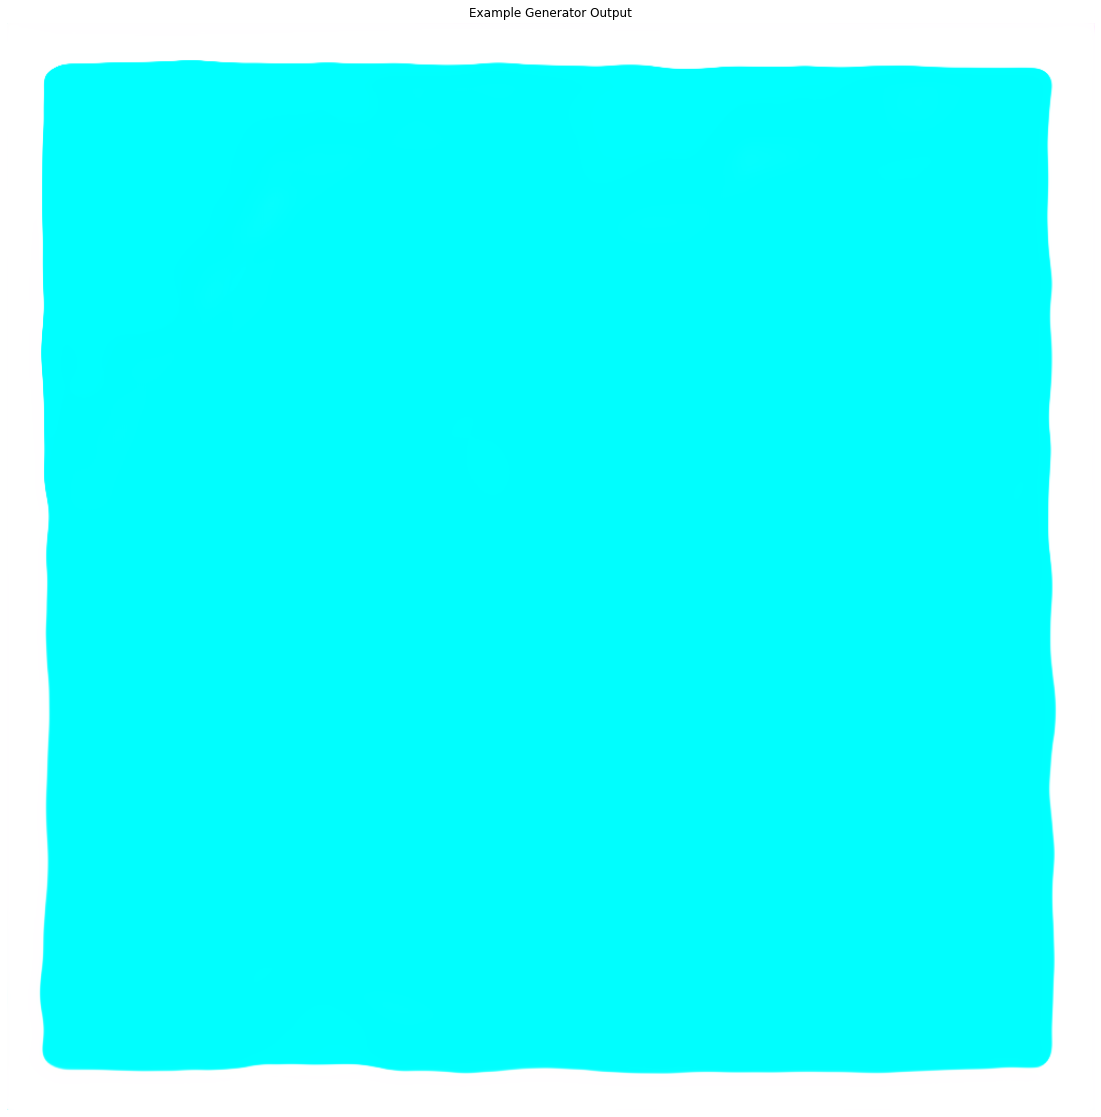

In [18]:
# load generator

generator.compile(optimizer=Adam(lr=0.0008), # per Foster, 2017 RMSprop(lr=0.0008)
                          loss=binary_crossentropy,
                          metrics=['accuracy'])
generator = tf.keras.models.load_model('/data/output/models/generator-2021-03-04_093146')

# generate new example of learned representation in latent space
noise = np.random.normal(0, 1, (1, 100))
res = generator.predict(noise)

# reinstate scale of pixel values to [0:1] and reshape
res = 0.5 * (res + 1)
res = res.reshape((1024, 1024, 3))

# Visualize result
plt.figure(figsize=(20, 20))
plt.imshow(res)
plt.title(f'Example Generator Output')
plt.axis('off')

# TODOs

### Changes made after 10 epoche run (V0.0)
---
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-02-512.png" width=20></img> kernel initializer in discriminator Conv2D layers set to RandomNormal(mean=0., stddev=0.02) (before default value = glorot_uniform aka Xavier)

### Changes to be made after 100 epoche run (for V0.5)
---
- Batch size 32 --> 64. Potentially use increasing batch size (rather than decay of learning rate) see: https://stackoverflow.com/questions/50606995/how-to-change-the-batch-size-during-training  --> might lead to memory problems in current 44GB RAM VM
- Dynamically increase batch size instead of decaying learning rate to accelarate training see https://arxiv.org/abs/1711.00489
- check some filters on different Conv2D layers --> use smaller filter to detect relatively small features?
- adjust filter size for some layers (5x5 -> 10x10?) --> shrinking size too fast is not helpful. maybe add additional conv layers to shrink more slowely?
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-02-512.png" width=20></img> Discriminator Optimizer Adam -> RMSprop
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-02-512.png" width=20></img> Added discriminator.trainable = True/False flags to training functions for discriminator/generator (GAN) to ensure discriminator is actually trainable
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-02-512.png" width=20></img> So far only 3652 images were used for training (single image maps and map archives starting with X, Y or Z). The next training cycle will include maps starting with U, V or W --> added all available samples
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-14-512.png" width=20></img> add 'sample_img()' function to execute every 'sample_interval' - added but not tested
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-14-512.png" width=20></img> tune polarization method in input data pipeline which scales pictures to 1024 x 1024? OR randomly crop a 1024 x 1024 piece of the input image to better preserve size of objects rather than scaling everything to 1024x1024 ==> random crop changed to 512x512 due to OOM error in training on GPUs
==> pre-processing applied to input 100k input images of different size: random cropped 10 1024x1024 regions and dropping all black etc. images, generating over 700k cropped samples
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-02-512.png" width=20></img> implement tensorboard for model monitoring during training
- try zero centering (mean subtracting) input data?
- use Randomized ReLU instead of leaky see: https://arxiv.org/pdf/1505.00853.pdf
- add another loop in train_gan() over different steps within training loop?
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-02-512.png" width=20></img> add slight randomness to labels (see Chollet p. 307)
- implement wasserstein GAN with gradient penalty (WGAN-GP, see  Foster p. 115 ff)
- use Frechet Inception Distance (FIP) for evaluation of GAN performance (see https://arxiv.org/abs/1706.08500 )

# Notes - Besprechung Vorstudie 15.01.2021

- Ausdrücke aus der Game Welt evtl. näher erläutern erläutern bspw. "Game Assets"
- Spezifizierung Forschungsfragen --> Ziele etwas zu offen bspw. was heisst "sufficiently able to learn" --> include Frechet Inception Distance (FIP)
    -- konkretisieren
    -- 2 Milestones (konkret) formulieren für Ergebnis mit Termin pro Milestones für Vorstellung dieser Milestones (mit Thomas Koller im CC inkl. Vorstudie) --> Für Herrn Birbaumer am liebsten <b>Donnerstag Nachmittag</b>:
        --- Milestone 1: Frechet Distance für ersten milestone 1 + WGAN-GP? Einführung nochmals Vorstudie als überblick
        --- Milestone 2: ???
- Bewertung von Games / Vergleichsstudie --> wie können Game Devs dazu bewogen werden diese zu verwenden, was sind das für Kriterien
- 2-3 Wochen vor Abgabe "Abschlusspresentation" einplanen